# Handling advected emissions and satellite data

## Get advected emissions at a given time

In [41]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

In [25]:
day, month, year= '03','01','2021'
# due to a disappearance of data, this currently only works for the year of 2021
# I am working on fixing this

In [38]:
# the emssions are taken at the time of satellite overpasses and then the 
# satellite data is taken at the emissions' locations

# for a given day, we first load the ship locations of the entire day and the day before 
print('working on day:', day, month, year)
t1=pd.read_csv('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/emissions_tracked/{}/{}_{}'.format(year, month, day))
day_before = pd.to_datetime(year+ month+ day, format='%Y%m%d') - pd.Timedelta('1d')
try:
    t1_b=pd.read_csv('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/emissions_tracked/{}/{}_{}'.format(str(day_before.year), str(day_before.month).zfill(2), str(day_before.day).zfill(2)))    

    t1_b.particle=t1_b.particle+10000 
    # we add an arbitrary number to the particle column, which IDs individual ships
    #to distinguish the day and the day before
    t1=pd.concat( [t1_b, t1])
except FileNotFoundError: 
    print('location file not found for ',day, month, year )

t1=t1.set_index(pd.to_datetime(t1['hour']))
t1=t1.drop(columns=['hour']).sort_index()


working on day: 03 01 2021


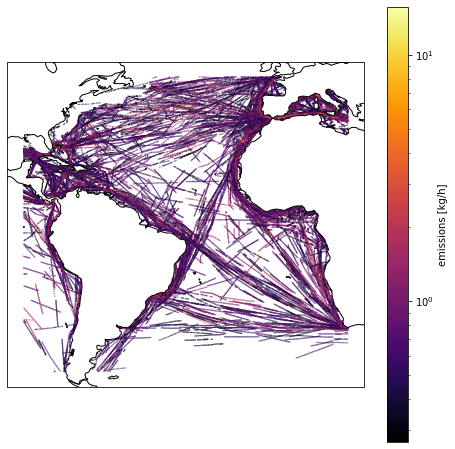

In [43]:
# here are 48h ship trajectories, all overlaid onto each other

plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(t1.longitude, t1.latitude, c=t1.signal, cmap='inferno',norm=matplotlib.colors.LogNorm(), s=0.05,)
plt.colorbar(label='emissions [kg/h]')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='white'))

In [48]:


# this section is for working with modis: we get the time of the overpass 
# in order to know how long we should follow the emissions with the wind

# if year=='2019':
#     infile = open('/home/users/pete_nut/IV_shiptracks/modis_tiles/atlantic_modis_swaths_intersect_{}_{}.pkl'.format(year, month),'rb')
# else: 
#     infile = open('/home/users/pete_nut/IV_shiptracks/modis_tiles/modis_swaths_intersect_{}_{}.pkl'.format(year, month),'rb')
# swath_dict = pickle.load(infile)
# infile.close()


# but here we just decide on an arbitrary time for demonstration

overpass_hour_min = '0830'
t_0=time.time()
print(overpass_hour_min)


time_of_overpass=pd.to_datetime(year+month+day+overpass_hour_min,  format='%Y%m%d%H%M')
# t_first_counted_emis=pd.to_datetime(year+month+day+'0000',  format='%Y%m%d%H%M')

# we cut the data down to the 24h preceding the time of interest (overpass)
t1_adv=t1.copy().loc[slice(time_of_overpass-pd.Timedelta('24h'), time_of_overpass),:]
#         print(t1_adv.loc[slice(time_of_overpass-pd.Timedelta('1d'), time_of_overpass),:])
# 
t1_adv=t1_adv.sort_values('particle')

# for each of the 24h preceding the overpass, we get the emissions from that time, 
# load the file that contains the advected emissions
# and finally replace the location of emission with the simulated location at 
# the time of interest
for i, t in enumerate(np.unique(t1_adv.index)):
#         print(t)
    print(i+1, '/',len(np.unique(t1_adv.index)))

    start_time=t1_adv.index.where(t1_adv.index==t).dropna()[0]
    if (time_of_overpass - start_time).total_seconds()<0 : continue
    else: None

    try:
        if ((year=='2019') or (year=='2018') or (year=='2017')):
            filloc = '/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/hysplit_adv_20m_non_isob/{}_{}_{}_{}:{}'
        else: 
            filloc = '/gws/nopw/j04/eo_shared_data_vol1/satellite/modistracks/hysplit_adv_20m_non_isob/{}_{}_{}_{}:{}'
        # this csv file has the locations where emissions from year, month, day, 
        # start_time end up at any given moment within 24h in 5min steps
        traj_read=pd.read_csv(filloc.format(                
        year, str(start_time.month).zfill(2), str(start_time.day).zfill(2), str(start_time.hour).zfill(2), str(start_time.minute).zfill(2)))
        traj_read.jday=pd.to_datetime(traj_read.jday)

        traj_read=traj_read[traj_read.jday==time_of_overpass]

        if len(traj_read) != len(t1_adv[t1_adv.index==t]):
            for i in range(1,len(t1_adv[t1_adv.index==t])+1):
                if not np.isin(i, np.unique(traj_read.particle)) : 
                    print('missing particle', i)
                    new_row = {'particle':i, 'jday':time_of_overpass, 'lat':np.nan, 'lon':np.nan ,'alt':np.nan ,'timestep':np.nan }
                    #append row to the dataframe
                    traj_read=traj_read.append(new_row, ignore_index=True)
                    traj_read=traj_read.sort_values('particle')
                else: None
        else: None
        t1_adv.latitude[t1_adv.index==t]=traj_read.lat.values
        t1_adv.longitude[t1_adv.index==t]=traj_read.lon.values

    except (FileNotFoundError,): #ValueError
        t1_adv.latitude[t1_adv.index==t]=np.nan
        t1_adv.longitude[t1_adv.index==t]=np.nan
        print('no hysplit data for {}'.format(start_time))


#     interp_adv=t1_adv.groupby('particle').resample('5T').interpolate()
#     interp_adv['overpass']=time_of_overpass


#     # clean up
#     interp_adv=interp_adv.drop(columns=['mass', 'y', 'x'])
# #         plt.scatter(interp_adv.longitude, interp_adv.latitude, s=0.1)

#     # subset the emission traj to the observation window in both time and space 
#     mask=[(interp_adv['latitude']<observation_window[0][1])&
#       (interp_adv['longitude']<observation_window[1][1])&
#       (interp_adv['latitude']>observation_window[0][0])&
#       (interp_adv['longitude']>observation_window[1][0])]

#     interp_adv=interp_adv[mask[0]]#.loc[(slice(None),slice(t_first_counted_emis, time_of_overpass)),:]
#     # sometimes, this leaves no tracks to look at
#     if (len(interp_adv.dropna()) == 0) : 
#         print('no overlapping data')
#         continue


# #get modis data
#     # mod_hr=read_data_list(modis_daily,
#     #                    ['Cloud_Top_Temperature'])
#     print('loading modis file') 
#     mod_lr=read_data_list(filename,
#                         ['Cloud_Effective_Radius',
#                         'Cloud_Effective_Radius_Uncertainty', 
#                         'Cloud_Phase_Optical_Properties',
#                         'Cloud_Water_Path',
#                         'Cloud_Optical_Thickness',
#                         # 'cloud_top_pressure_1km'
#                         'cloud_top_temperature_1km'
#                         ], product='MOD06_HACK')
#     # mod_lr_2=read_data_list(filename, ['Cloud_Top_Height'], product='MOD06_HACK')
#     print('done loading modis file',filename)
#     # want liquid clouds with low uncertainty in r_eff estimate
#     sat_mask=(mod_lr[2].data==2) & (mod_lr[1].data<=10)
#     xy=UngriddedDataList([mod_lr[0][sat_mask], mod_lr[3][sat_mask], mod_lr[4][sat_mask], mod_lr[5][sat_mask]])
#     # xy2=UngriddedDataList([mod_lr_2[0]] )

#     modis_coord_box=[[mod_lr.coords('latitude')[0].points.min(), 
#        mod_lr.coords('latitude')[0].points.max()],
#        [mod_lr.coords('longitude')[0].points.min(),           
#        mod_lr.coords('longitude')[0].points.max()]]

#     mask_hysplit_from_modis=[(interp_adv['latitude']<modis_coord_box[0][1])&
#       (interp_adv['longitude']<modis_coord_box[1][1])&
#       (interp_adv['latitude']>modis_coord_box[0][0])&
#       (interp_adv['longitude']>modis_coord_box[1][0])]

#     interp_adv=interp_adv[mask_hysplit_from_modis[0]]
#     # sometimes, this leaves no tracks to look at
#     if (len(interp_adv.dropna()) == 0) : 
#         print('no overlapping data')
#         continue

#     # get shifted trajectories for unpolluted counterfactual
#     offsets=get_offset(interp_adv, np.unique(interp_adv.particle.values), 0.3)

#     shifted_adv=interp_adv.copy()
#     shifted_adv2=interp_adv.copy()
#     shifted=[shifted_adv,interp_adv,shifted_adv2]
#     n_traj = len(shifted)
#     k = n_traj//2

#     for i in np.unique(interp_adv.particle.values):
#         i=int(i)
#         for j, current_traj in enumerate(shifted):
#             current_traj.loc[i].longitude = interp_adv.loc[i].longitude.values + (j-k) * offsets[i][0]
#             current_traj.loc[i].latitude = interp_adv.loc[i].latitude.values + (j-k) * offsets[i][1]

#     for j, current_traj in enumerate(shifted):
#         current_traj.index = current_traj.index.droplevel(0)


#     # wrangle datasets (need to be merged before collocating to save time)
#     concatenated=pd.concat(shifted)

#     # create cis UngriddedData object from DataFrame
#     tracks_ungridded=UngriddedData_from_data_frame(
#         concatenated,
#         ['signal'])

#     print('collocate emissions and modis')
#     # collocate the modis and emission data and append to collection dataframe
#     try:
#         coll = xy.collocated_onto(tracks_ungridded[0], 'box', fill_value=-999,h_sep='10km')
#         # coll2 = xy2.collocated_onto(tracks_ungridded[0], 'box', fill_value=-999,h_sep='10km')
#         # 0=reff, 2=npoints, 3=LWP, 6=COT
#         coldat=UngriddedDataList([coll[0], coll[2], coll[3], coll[6], coll[9]]).as_data_frame()
#         # print(coldat)
#         coldat=coldat.rename(
#             columns={'Cloud Particle Effective Radius two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'r_eff',
#                     'Number of points used to calculate the mean of Cloud Particle Effective Radius two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'npoints',
#                     'Column Water Path two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um) (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'LWP',
#                     'Cloud Optical Thickness two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'COT',
#                     # 'Cloud Top Pressure at 1-km resolution from LEOCAT, Cloud Top Pressure Level rounded to nearest 5 mb':'CTT'
#                     'Cloud Top Temperature at 1-km resolution from LEOCAT, Temperature from Ancillary Data at Retrieved Cloud Top Pressure Level':'CTT'
#                     }
#         )

#         middle = np.shape(coldat)[0]//n_traj
#         saveframe=coldat[k*middle :(k+1) * middle].copy()

#         saveframe['signal']=concatenated.signal[:middle].values
#         saveframe['overpass']=concatenated.overpass[:middle].values
#         saveframe['particle']=concatenated.particle[:middle].values
#         print('number of paths:',n_traj)
#         for n in range(n_traj):
#             if n==n_traj//2: continue
#             traj_name=str(n+1)
#             saveframe['latitude_'+traj_name]=coldat.latitude[n*middle:(n+1)*middle]
#             saveframe['longitude_'+traj_name]=coldat.longitude[n*middle:(n+1)*middle]
#             saveframe['r_eff_'+traj_name]=coldat.r_eff[n*middle:(n+1)*middle]
#             saveframe['LWP_'+traj_name]=coldat.LWP[n*middle:(n+1)*middle]
#             saveframe['COT_'+traj_name]=coldat.COT[n*middle:(n+1)*middle]
#             saveframe['CTT_'+traj_name]=coldat.CTT[n*middle:(n+1)*middle]
#             saveframe['npoints_'+traj_name]=coldat.npoints[n*middle:(n+1)*middle]







#         collect_overpasses=collect_overpasses.append(saveframe)
#         print(len(saveframe.dropna()), 'data points collocated')
#     except ValueError: 
#         print('no data for'+filename)
#         continue
#     t_1=time.time()
#     print('time elapsed for this modis file:', t_1-t_0)
# if terra:
#     try:collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')

#     except tables.exceptions.HDF5ExtError: 
#         time.sleep(60)
#         collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')
# else:
#     try: collect_overpasses.to_hdf(savepath_a.format(year, month,day), key='df')
#     except tables.exceptions.HDF5ExtError:
#         time.sleep(60)
#         collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')


0830
1 / 24
missing particle 1623
2 / 24


/tmp/ipykernel_14001/1379671515.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_adv.latitude[t1_adv.index==t]=traj_read.lat.values
/tmp/ipykernel_14001/1379671515.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t1_adv.longitude[t1_adv.index==t]=traj_read.lon.values


3 / 24
4 / 24
5 / 24
6 / 24
7 / 24
8 / 24
9 / 24
10 / 24
11 / 24
12 / 24
13 / 24
14 / 24
15 / 24
16 / 24
17 / 24
18 / 24
19 / 24
20 / 24
21 / 24
22 / 24
23 / 24
24 / 24


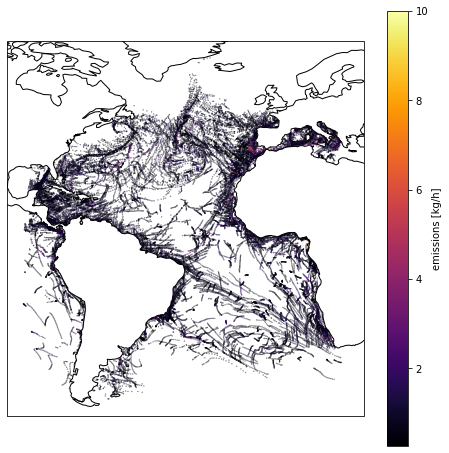

In [49]:
# here, all the trajectories are advected to their locations when the satellite passes
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(t1_adv.longitude, t1_adv.latitude, c=t1_adv.signal, cmap='inferno', s=0.05, vmax=10)
plt.colorbar(label='emissions [kg/h]')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='white'))